## Sentiment Analysis on the IMDB dataset using gpt-3.5-turbo

#### Imports

In [1]:
import pandas as pd
from datasets import  load_dataset
import openai
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
from tqdm.notebook import tqdm
from util_functions import compute_metrics, print_eval_metrics, save_metrics
tqdm.pandas()

#### Function definition

In [27]:
def review_classifier_gpt35(text: str) -> str:
    """
    Classifies whether a movie review is positive or negative,
    using Openai's gpt-3.5-turbo model.

    Args:
    text: str
        The review string
    response_text: str
        The prediction
    """
    messages = [
        {"role": "user",
         "content": f"""Analyze the following movie review and determine if the sentiment is: positive or negative.
                                        Return answer in single word as either positive or negative: {text}"""}
        ]
    
    response = openai.ChatCompletion.create(
                      model="gpt-3.5-turbo",
                      messages=messages,
                      max_tokens=1,
                      n=1,
                      stop=None,
                      temperature=0.1,
                      request_timeout=4)

    response_text = response.choices[0].message.content.strip().lower()

    return response_text

#### Load dataset and openai key

In [3]:
imdb = load_dataset("imdb")
openai.api_key = os.environ.get('OPENAI_API_KEY')  # Enter your Openai api key

#### Select a sample for testing

In [4]:
n_samples = 2500  # Select the number of samples to test
test_df = pd.DataFrame(imdb['test']).sample(n_samples, random_state=42).reset_index(drop=True)
print(f"Testing gpt-3.5-turbo model's performance on --{len(test_df)}-- movie reviews")

Testing gpt-3.5-turbo model's performance on --2500-- movie reviews


In [5]:
test_df.loc[:, 'pred'] = None
test_df

,text,label,pred
0,I could not believe how terrible and boring th...,0,None
1,I rented Boogie Nights last week and I could t...,1,None
2,"First off, this movie is not near complete, my...",0,None
3,I watched this mini in the early eighties. Sam...,1,None
4,This movie was never intended as a big-budget ...,1,None
...,...,...,...
2495,Following on directly from the last episode of...,1,None
2496,"""The King of Queens"" could be divided into two...",1,None
2497,the fact that there was so much fuss is ironic...,1,None
2498,"Told in flashback, the film opens in 1989 with...",1,None


#### Classify test dataset

In [ ]:
max_retries = 10
for index, row in tqdm(test_df.iterrows(), total=len(test_df), colour='green'):
    if pd.isnull(row['pred']):
        retries = 0
        while retries < max_retries:
            try:
                test_df.loc[index, 'pred'] = review_classifier_gpt35(row['text'])
                test_df.to_csv('checkpoints.csv', index=False)
                break
            except Exception as e:
                retries += 1
                print(f"Error processing row {index}, retry {retries}/{max_retries}: {e}")
                if retries == max_retries:
                    print(f"Maximum retries reached for row {index}. Skipping.")
                    break  


#### Transform predictions column and store results in .csv file

In [20]:
test_df.loc[test_df['pred'] == 'negative', 'pred'] = 0
test_df.loc[test_df['pred'] == 'positive', 'pred'] = 1
test_df['pred'] = test_df['pred'].astype(np.int64)
test_df.to_csv('predictions.csv', index=True)
print("Stored results.")


Stored results.


In [21]:
test_df

,text,label,pred
0,I could not believe how terrible and boring th...,0,0
1,I rented Boogie Nights last week and I could t...,1,1
2,"First off, this movie is not near complete, my...",0,0
3,I watched this mini in the early eighties. Sam...,1,1
4,This movie was never intended as a big-budget ...,1,1
...,...,...,...
2495,Following on directly from the last episode of...,1,1
2496,"""The King of Queens"" could be divided into two...",1,1
2497,the fact that there was so much fuss is ironic...,1,1
2498,"Told in flashback, the film opens in 1989 with...",1,1


#### Compute Metrics

In [28]:

metrics = compute_metrics(true_labels=test_df['label'].to_list(), 
                          predicted_labels=test_df['pred'].to_list())
print_eval_metrics(metrics)
save_metrics(metrics=metrics, file_name='metrics_sentiment')

The precision score is:  0.96
The recall score is:  0.93
The f1_score score is:  0.94
The accuracy score is:  0.94
Saved metrics.json!


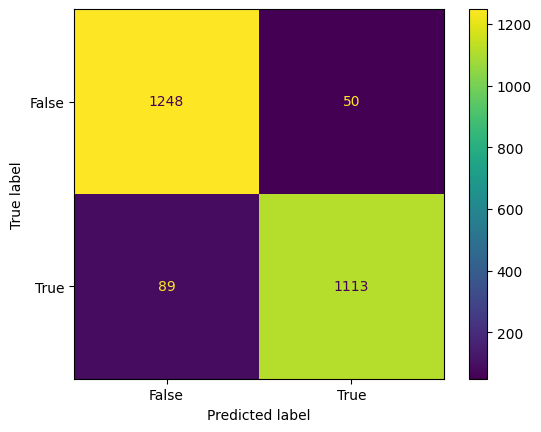

In [29]:
conf_matrix = confusion_matrix(y_true=test_df['label'].values, 
                               y_pred=test_df['pred'].values)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                                    display_labels=[False, True])
cm_display.plot()
plt.show()

In [30]:
errors_df = test_df[test_df['label'] != test_df['pred']]
errors_df.to_csv('errors.csv')

##### Appendix: Token estimation

In [31]:
df = test_df
encoding = tiktoken.get_encoding("cl100k_base")
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
df["tokens"] = df['text'].apply(encoding.encode)
df["n_tokens"] = df['tokens'].apply(len)

promt = """Analyze the following movie review and determine if the sentiment is: positive or negative.
            Return answer in single word as either positive or negative:"""
n_prompt_tokens= len(encoding.encode(promt))

In [32]:
print(f"Total number of reviews: {len(df)}")
print(f"Total number of tokens: {df.n_tokens.sum()}")
print(f"Tokens per review: {int(df.n_tokens.mean())}")
print(f"Number of token prompts: {n_prompt_tokens}")
print(f"Tokens per request: {int(df.n_tokens.mean() + n_prompt_tokens + 1)}")
print(f"Tokens spent: {(int(df.n_tokens.mean() + n_prompt_tokens + 1) * len(df))}")

Total number of reviews: 2500
Total number of tokens: 716854
Tokens per review: 286
Number of token prompts: 29
Tokens per request: 316
Tokens spent: 790000
